In [1]:
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import manifold

/opt/anaconda3/envs/mothership/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nargestabari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data = tfds.load('imdb_reviews', split='train', shuffle_files=True)
assert isinstance(data, tf.data.Dataset)

In [4]:
print(data)
print(len(data))
print(data.take(1))

d = tfds.as_dataframe(data)
print(d.head())
print(len(d))

<_OptionsDataset shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>
25000
<TakeDataset shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>
   label                                               text
0      0  b"This was an absolutely terrible movie. Don't...
1      0  b'I have been known to fall asleep during film...
2      0  b'Mann photographs the Alberta Rocky Mountains...
3      1  b'This is the kind of film for a snowy Sunday ...
4      1  b'As others have mentioned, all the women that...
25000


## Using Doc2Vec to get sentence embeddings

In [5]:
d['tokenized_text']= d['text'].str.decode("utf-8").apply(word_tokenize)

In [33]:
d.head(5)

,label,text,tokenized_text
0,0,"b""This was an absolutely terrible movie. Don't...","[This, was, an, absolutely, terrible, movie, ...."
1,0,b'I have been known to fall asleep during film...,"[I, have, been, known, to, fall, asleep, durin..."
2,0,b'Mann photographs the Alberta Rocky Mountains...,"[Mann, photographs, the, Alberta, Rocky, Mount..."
3,1,b'This is the kind of film for a snowy Sunday ...,"[This, is, the, kind, of, film, for, a, snowy,..."
4,1,"b'As others have mentioned, all the women that...","[As, others, have, mentioned, ,, all, the, wom..."


In [6]:
# tag and train the doc2vec model 
tagged =[ TaggedDocument(k, [i]) for i,k in enumerate(d['tokenized_text'])]

model = Doc2Vec(tagged, vector_size=50, window=4, min_count=1, epochs=3)

In [7]:
d['vectors_doc2vec'] = d['tokenized_text'].apply(model.infer_vector)
d['vectors_doc2vec2'] = d['tokenized_text'].apply(model.infer_vector)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

print((d['vectors_doc2vec'][0].shape))

# s = cosine_similarity(list(d['vectors_doc2vec'][0])
#                            , list(d['vectors_doc2vec2'][0]))

(50,)


##  Clustering using Euclidean distance

In [37]:

wcss = []
for i in range(1,10):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(list(d['vectors_doc2vec']))
    wcss.append(kmeans.inertia_)


[23096.511231535, 20771.02636366563, 19973.365876941207, 19490.679745020247, 19086.945679074484, 18750.041812903102, 18451.776698596088, 18242.90951038898, 18063.24966788147]


Text(0.5, 1.0, 'elbow method')

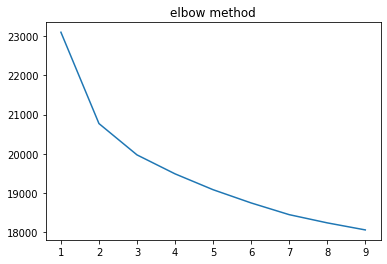

In [38]:
print(wcss)

# elbow
plt.plot(range(1,10), wcss)
plt.title('elbow method')

In [39]:
# silhouette
wcss =[]
sil = []
for i in range(2,4):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=42)
    labels = kmeans.fit_predict(list(d['vectors_doc2vec']))
    wcss.append(kmeans.inertia_)
    sil_avg = silhouette_score(list(d['vectors_doc2vec']), labels)
    sil.append(sil_avg)
    
    print(f"for cluster {i}, avg sil_score is: {sil_avg}")



for cluster 2, avg sil_score is: 0.18744505941867828
for cluster 3, avg sil_score is: 0.06909976154565811


In [40]:
kmeans = cluster.KMeans(n_clusters=2, init='k-means++', max_iter=300, random_state=42)
labels = kmeans.fit_predict(list(d['vectors_doc2vec']))
print(len(labels))
print(kmeans.inertia_)

d['predicted_doc2vec'] = labels

print(f" f1: {f1_score(d['label'], d['predicted_doc2vec'])}")
print(f" precision: {precision_score(d['label'], d['predicted_doc2vec'])}")
print(f" recall: {recall_score(d['label'], d['predicted_doc2vec'])}")

d.to_pickle('clustering_project.pkl')

25000
20771.02636366563
 f1: 0.4431441388726351
 precision: 0.5674325674325674
 recall: 0.36352


In [6]:
d = pd.read_pickle('./clustering_project.pkl')

print(d.head(3))
# print(d.vectors_doc2vec[0])


   label                                               text  \
0      0  b"This was an absolutely terrible movie. Don't...   
1      0  b'I have been known to fall asleep during film...   
2      0  b'Mann photographs the Alberta Rocky Mountains...   

                                      tokenized_text  \
0  [This, was, an, absolutely, terrible, movie, ....   
1  [I, have, been, known, to, fall, asleep, durin...   
2  [Mann, photographs, the, Alberta, Rocky, Mount...   

                                     vectors_doc2vec  predicted_doc2vec  
0  [0.18453163, -0.11183806, -0.11965283, -0.0692...                  0  
1  [0.05102559, -0.15731633, -0.09570343, -0.1796...                  0  
2  [0.007702496, -0.110383846, -0.1289385, 0.0286...                  0  


In [28]:
X_embedded = manifold.TSNE(n_components=2, init='pca').fit_transform(list(d['vectors_doc2vec']))

d['doc2vec_embedded_tsne'] = list(X_embedded)

# d.to_pickle('./clustering_project.pkl')
# d = pd.read_pickle('./clustering_project.pkl')




In [29]:

dataplot = pd.DataFrame(X_embedded, columns=['X_tsne', 'Y_tsne'])

dataplot['label'] = d['label']
dataplot['predicted_doc2vec'] = d['predicted_doc2vec']

print(dataplot.head(2))


      X_tsne     Y_tsne  label  predicted_doc2vec
0  -2.366267  -2.697527      0                  0
1  14.385499  26.204456      0                  0


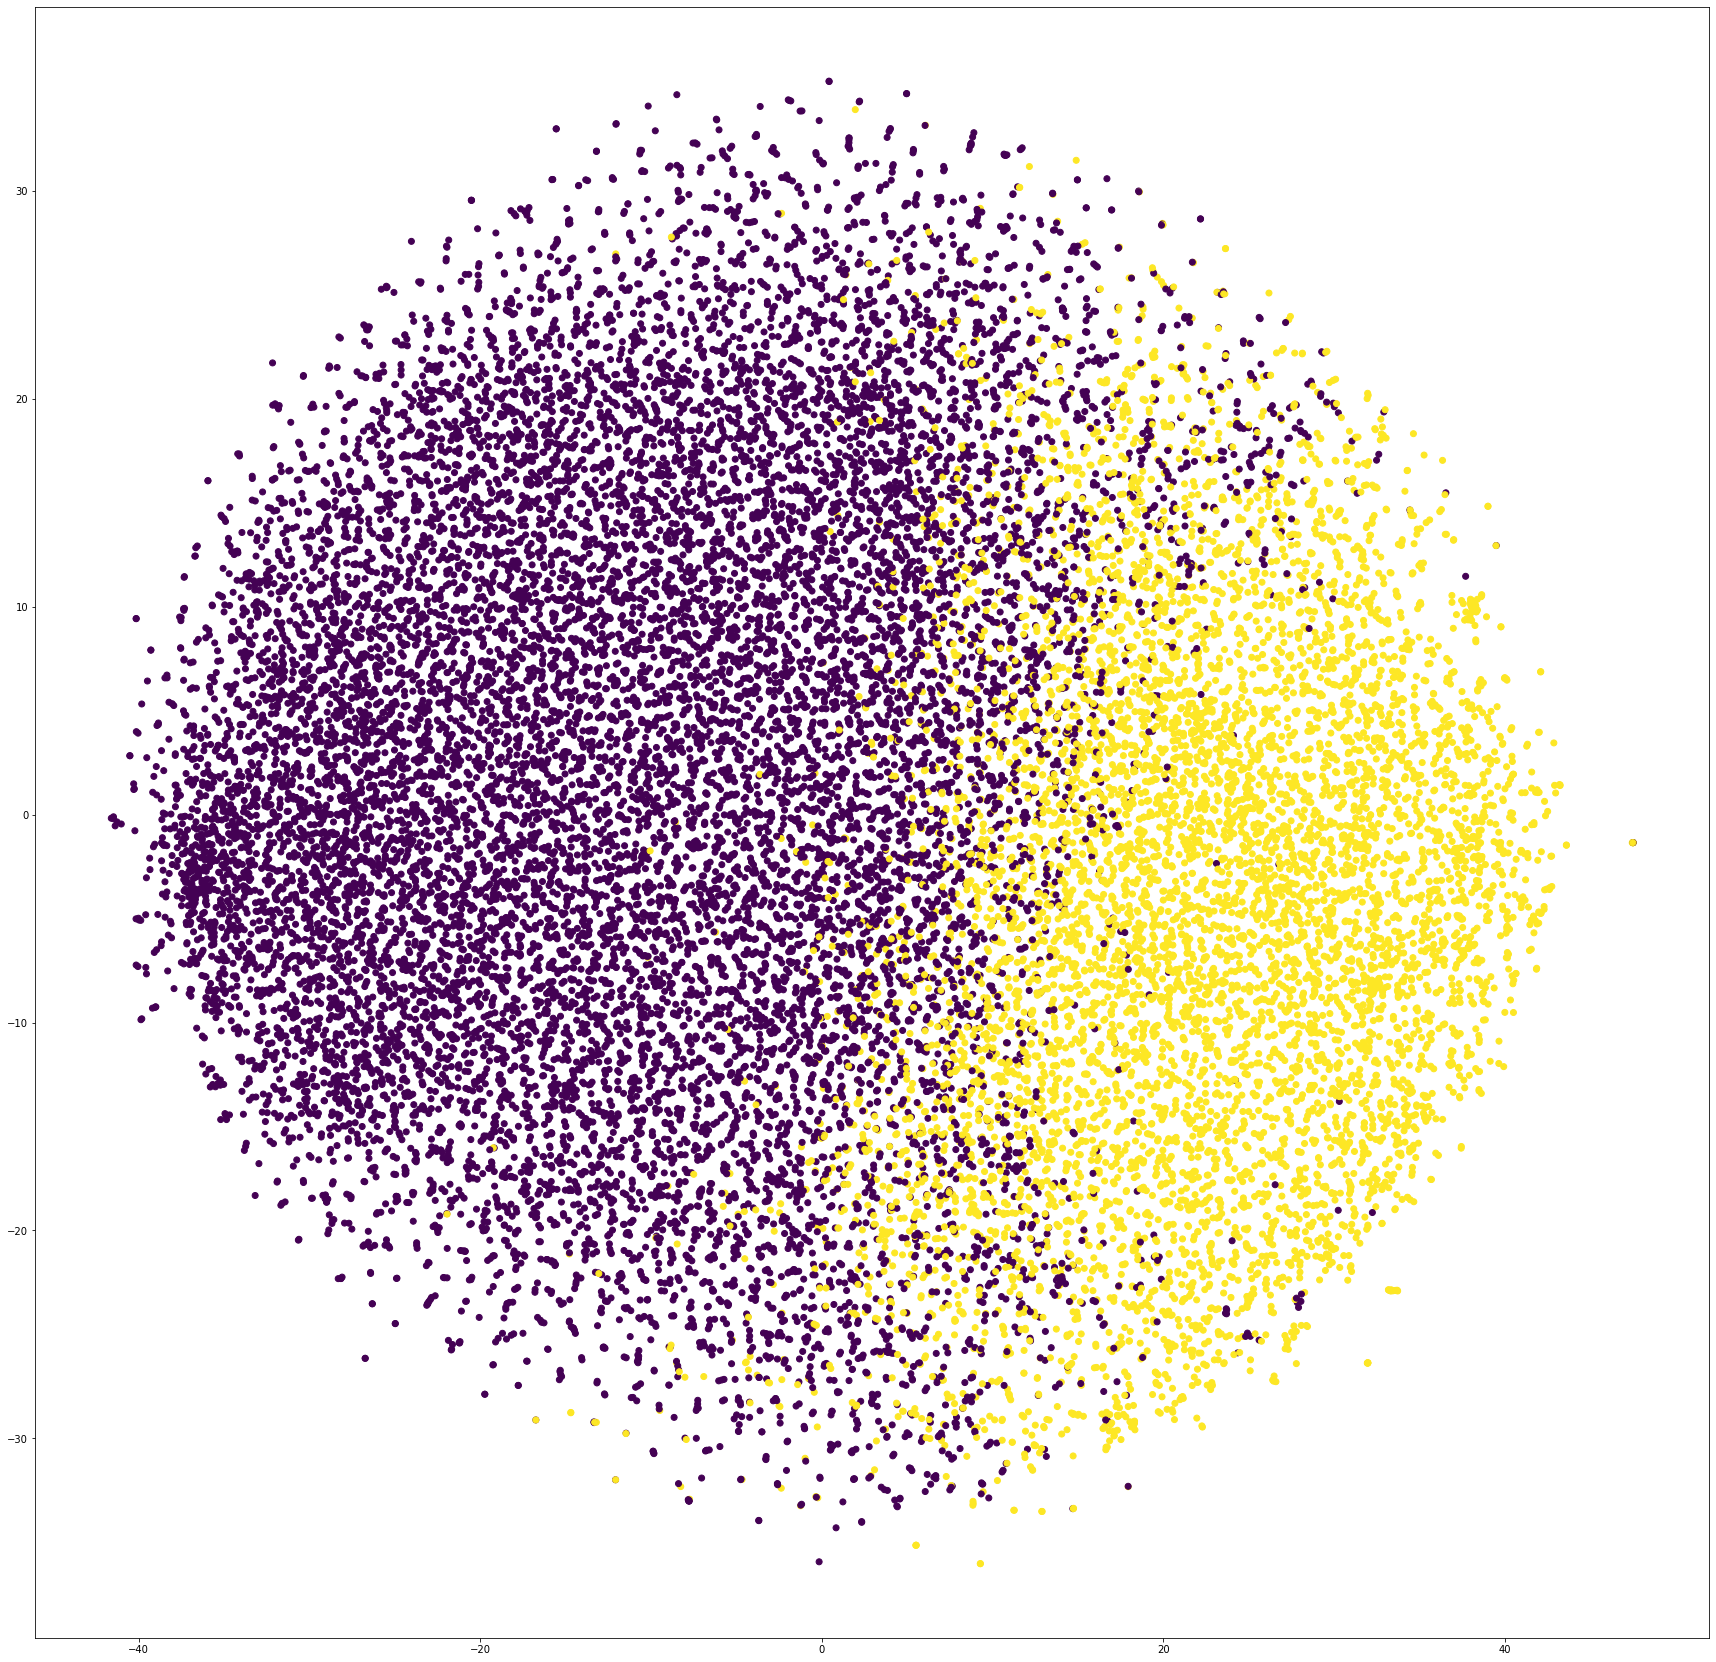

In [43]:

fig, ax = plt.subplots(figsize=(30, 30)) 
ax.scatter(dataplot.X_tsne, dataplot.Y_tsne, c=dataplot.predicted_doc2vec)
plt.show() 

# labels are not seperable in this manifold... maybe it's the embedding's problem. 
# but maybe LDA? 

## LDA on embeddings


In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

x_transform = lda.fit_transform(list(d['vectors_doc2vec']), list(d.label))
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(list(d['vectors_doc2vec']), list(d.label))))

print(x_transform)
predicted_lda = lda.predict(list(d['vectors_doc2vec']))

print(predicted_lda)

print(f1_score(d.label, predicted_lda))
# fig, ax = plt.subplots(figsize=(30, 30)) 
# ax.scatter(dataplot.X_tsne, dataplot.Y_tsne, c=dataplot.label)
# plt.show() 

Accuracy of LDA classifier on training set: 0.76
[[-0.44677045]
 [ 0.40387524]
 [ 0.29185053]
 ...
 [-5.66559417]
 [ 0.44208024]
 [-1.18499194]]
[0 1 1 ... 0 1 0]
0.7601382213925408
